<a href="https://colab.research.google.com/github/natshaporova/develope/blob/main/Multi_Classification_with_PreTrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multiclass image classification with Tensorflow transfer learning (InceptionV3) 

**resources:**
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

https://github.com/kennethleungty/TensorFlow-Transfer-Learning-Image-Classification

**dataset:** 
https://www.kaggle.com/code/pavansanagapati/simple-tutorial-on-object-recognition/input

In [38]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE
import pathlib

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

Tensorflow version 2.11.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
proj_path = '/content/drive/My Drive/datasets/data'
model_saving_path = '/content/drive/My Drive/models'
data_dir_list = os.listdir(proj_path)
data_dir_list

['cars', 'bike', 'cats', 'dogs', 'flowers', 'horses', 'human']

In [23]:
#load dataset
batch_size = 32
#size of the image that is in dataset
img_height = 128
img_width = 128
# img_size for model
IMG_SIZE = 150

#get correct path to the data_dir
data_dir = pathlib.Path(proj_path).with_suffix('')

#prepare the train set (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1803 files belonging to 7 classes.
Using 1443 files for training.


In [5]:
#preapare the validation set (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1803 files belonging to 7 classes.
Using 360 files for validation.


In [6]:
#try to create test dataset
#in mathematics, the cardinality of a set is a measure of the number of elements of the set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [11]:
#understanding dataset
num_train_examples = tf.data.experimental.cardinality(train_ds).numpy()
num_val_examples = tf.data.experimental.cardinality(val_ds).numpy()
num_test_examples = tf.data.experimental.cardinality(test_ds).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 46
Number of validation samples: 12
Number of test samples: 2


In [24]:
for c,v in train_ds:
  print(v.numpy())
  break



[1 1 1 3 1 0 0 1 2 0 5 6 0 1 6 3 0 1 5 2 6 4 1 2 3 6 5 1 4 1 4 0]


In [17]:
val_y = np.concatenate([y for x, y in val_ds], axis=0)

In [19]:
print(len(val_y))


296


In [25]:
train_y = np.concatenate([y for x, y in train_ds], axis=0)


In [26]:
len(train_y)

1443

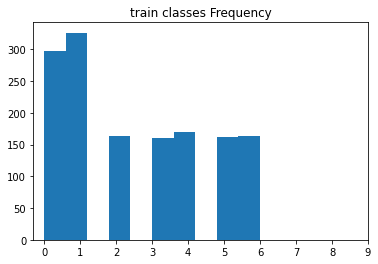

In [29]:
plt.hist(train_y)
plt.xticks(range(10))
plt.title('train classes Frequency')
plt.show()

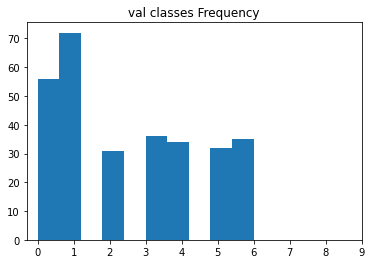

In [30]:
plt.hist(val_y)
plt.xticks(range(10))
plt.title('val classes Frequency')
plt.show()

In [32]:
unique, counts = np.unique(train_y, return_counts=True)
print(dict(zip(unique, counts)))


{0: 298, 1: 326, 2: 164, 3: 160, 4: 169, 5: 162, 6: 164}


{0: 298,   1: 326, 2: 164, 3: 160,   4: 169,    5: 162,   6: 164}
['cars', 'bike',    'cats', 'dogs', 'flowers', 'horses', 'human']

In [33]:
#one hot encode
num_classes = 7 
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [34]:
#one_hot_encode for all datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [35]:
#augmantation and resizing
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
resize = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  #tf.keras.layers.Rescaling(1./255)
])

In [ ]:
train_ds=train_ds.map(lambda x, y: (resize(x), y))
train_ds=train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds=train_ds.map(lambda x, y: (preprocess_input(x), y))

In [40]:
val_ds=val_ds.map(lambda x, y: (resize(x), y))
val_ds=val_ds.map(lambda x, y: (preprocess_input(x), y))

In [41]:
test_ds=test_ds.map(lambda x, y: (resize(x), y))
test_ds=test_ds.map(lambda x, y: (preprocess_input(x), y))

In [42]:
train_ds=train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [43]:
base_model = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [44]:
for layer in base_model.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
prediction = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(base_model.input,prediction)

In [45]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [46]:
history = model.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
46/46 [==============================] - 117s 2s/step - loss: 2.7610 - accuracy: 0.2204 - val_loss: 2.0312 - val_accuracy: 0.3345
Epoch 2/10
46/46 [==============================] - 104s 2s/step - loss: 1.8777 - accuracy: 0.3791 - val_loss: 1.3463 - val_accuracy: 0.5743
Epoch 3/10
46/46 [==============================] - 96s 2s/step - loss: 1.3071 - accuracy: 0.5731 - val_loss: 1.0590 - val_accuracy: 0.6689
Epoch 4/10
46/46 [==============================] - 101s 2s/step - loss: 1.0857 - accuracy: 0.6389 - val_loss: 0.8872 - val_accuracy: 0.7095
Epoch 5/10
46/46 [==============================] - 101s 2s/step - loss: 0.8802 - accuracy: 0.7131 - val_loss: 0.7256 - val_accuracy: 0.7703
Epoch 6/10
46/46 [==============================] - 101s 2s/step - loss: 0.7739 - accuracy: 0.7443 - val_loss: 0.6495 - val_accuracy: 0.7973
Epoch 7/10
46/46 [==============================] - 101s 2s/step - loss: 0.7018 - accuracy: 0.7630 - val_loss: 0.6002 - val_accuracy: 0.8142
Epoch 8/10
46/

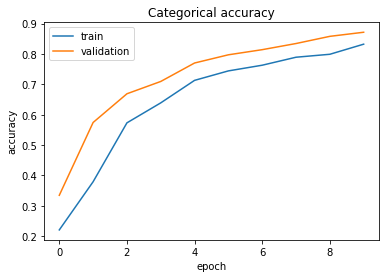

In [48]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [50]:
model.save(f'{model_saving_path}/12.03.1/')

In [51]:
print(tf.data.experimental.cardinality(test_ds).numpy())

2


In [52]:
preds = model.predict(test_ds)

2/2 [==============================] - 6s 1s/step


In [53]:
result = model.evaluate(test_ds)

2/2 [==============================] - 4s 1s/step - loss: 0.4825 - accuracy: 0.8750


{'loss': 0.48246458172798157, 'accuracy': 0.875}

In [54]:
dict(zip(model.metrics_names, result))

{'loss': 0.48246458172798157, 'accuracy': 0.875}